In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

# Finding the best hyper-parameters

Some text about finding hyper-parameters.

# Fetch the data and load it

This is a repeat of the previous notebook. Downloads the data and fits a simple decision tree classifier.

In [2]:
import os
from urllib.request import urlretrieve

url = ("https://archive.ics.uci.edu/ml/machine-learning-databases"
       "/adult/adult.data")
local_filename = os.path.basename(url)
if not os.path.exists(local_filename):
    print("Downloading Adult Census datasets from UCI")
    urlretrieve(url, local_filename)

In [3]:
names = ("age, workclass, fnlwgt, education, education-num, "
         "marital-status, occupation, relationship, race, sex, "
         "capital-gain, capital-loss, hours-per-week, "
         "native-country, income").split(', ')    
data = pd.read_csv(local_filename, names=names)
data = data.drop('fnlwgt', axis=1)

In [4]:
target = data['income']
features_data = data.drop('income', axis=1)
features = pd.get_dummies(features_data)

In [5]:
X = features.values.astype(np.float32)
y = (target.values == ' >50K').astype(np.int32)

In [6]:
from sklearn.model_selection import train_test_split

X_dev, X_eval, y_dev, y_eval = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [7]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=8)

In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_dev, y_dev, cv=5, scoring='roc_auc')
print("ROC AUC Decision Tree: {:.4f} +/-{:.4f}".format(
      np.mean(scores), np.std(scores)))

ROC AUC Decision Tree: 0.9006 +/-0.0023


# Tuning your estimator

Hyper-parameters are not directly learnt by the classifier or regressor from the data. They need setting from the outside. An example of a hyper-parameter is `max_depth` for a decision tree classifier. In `scikit-learn` you can spot them as the parameters that are passed to the constructor of your estimator.

The best value of a hyper-parameter depends on the kind of problem you are solving:

* how many features and samples do you have?
* mostly numerical or mostly categorical features?
* is it a regression or classification task?

Therefore you should optimise the hyper-parameters for each problem, otherwise the performance of your classifier will not be as good as it could be.

## Search over a grid of parameters

This is the simplest strategy: you try every combination of values for each hyper-parameter.

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [1, 2, 4, 8, 16, 32]}
grid_search = GridSearchCV(clf, param_grid=param_grid, scoring='roc_auc')

In [10]:
grid_search.fit(X_dev, y_dev)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 4, 8, 16, 32]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### Question

Print out the values of `max_depth` tried, and the average train and test scores for each.

(Try and retrieve the `max_depth` values from the `grid_search` object, not the parameter grid.)

In [ ]:
# %load solutions/grid_search_list_values.py

### Question

Compare the test and train performance at for each value of `max_depth` to that obtained from the previous validation curve example by making a plot similar to `plot_validation_curve`.


In [ ]:
# %load solutions/grid_search_max_depth.py

### Question

Extend the parameter grid to also search over different values for the `max_features` hyper-parameter. (Try: 3, 6, 12, 24, 48, and 96 if you need inspiration)

In [ ]:
# %load solutions/grid_search_max_depth_and_max_features.py

### Question

How many different models/hyper-parameter combinations did you just evaluate? What are the best three combinations? (Should you rank by train or test score?)

In [ ]:
# %load solutions/grid_search_best_three.py

### Question

Reuse your plotting from before to show how the score varies as a function of `max_depth`. Do you notice how we repeatedly evaluate the classifier at the same value of `max_depth`? Before going to the next section, see if you can think of a way to get a better picture of the behaviour as a function of `max_depth` without increasing the number of times you have to fit a model.

Best test score: 0.8975


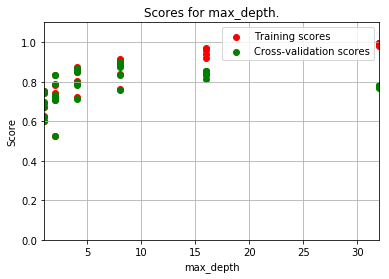

In [15]:
#plot_grid_scores("max_depth", grid_search.cv_results_)

## Random grid search

An alternative to the exhaustive grid search is to sample parameter values at random. This has two main benefits over an exhaustive search:
* A budget can be chosen independent of the number of parameters and possible values.
* Adding parameters that do not influence the performance does not decrease efficiency.

In [16]:
from scipy.stats import randint as sp_randint

from sklearn.model_selection import RandomizedSearchCV

param_grid = {"max_depth": sp_randint(1, 32),
              "max_features": sp_randint(1, 96),
             }
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=36, scoring='roc_auc')
random_search.fit(X_dev, y_dev)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=36, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1120d0828>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1196e2898>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

Best test score: 0.8943


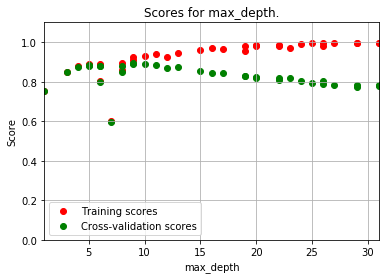

In [17]:
plot_grid_scores("max_depth", random_search.cv_results_)

For the same number of model evaluations you get a much better view of how the performance varies as a function of `max_depth`. This is a big advantage especially if one of the hyper-parameters does not influence the performance of the estimator. Though as you increase the number of dimensions making a projection into just one becomes more noisy.

In [18]:
param_grid = {"max_depth": sp_randint(1, 32),
              "max_features": sp_randint(1, 96),
              "min_samples_leaf": sp_randint(15, 40)
             }
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=36, scoring='roc_auc')
random_search.fit(X_dev, y_dev)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid=True, n_iter=36, n_jobs=1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112b56550>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112b56940>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112b799b0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

Best test score: 0.9038


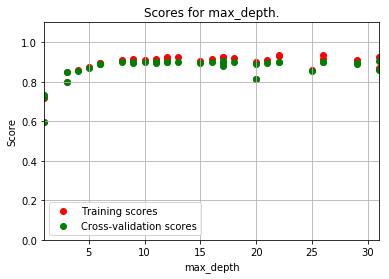

In [19]:
plot_grid_scores("max_depth", random_search.cv_results_)

Best test score: 0.9038


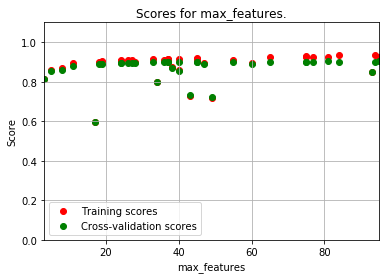

In [20]:
plot_grid_scores("max_features", random_search.cv_results_)

Best test score: 0.9038


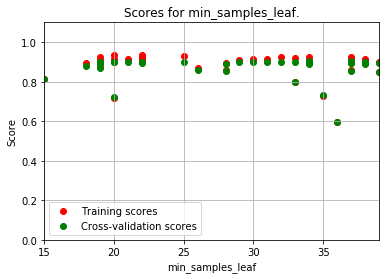

In [21]:
plot_grid_scores("min_samples_leaf", random_search.cv_results_)

In [22]:
random_search.best_params_

{'max_depth': 31, 'max_features': 95, 'min_samples_leaf': 34}

## Bayesian optimisation

Neither the exhaustive grid search nor random search adapt their search for the best hyper-parameter as they evaluate points. For the grid all points are chosen upfront, and for random search all of them are chosen at random.

It makes sense to use the knowledge from the first few evaluations to decide what hyper-parameters to try next. This is what tools like `scikit-optimize` try and do. The technique is known as bayesian optimisation or sequential model based optimisation.

The basic algorithm goes like this:
* evaluate a new set of hyper-parameters
* fit a regression model to all sets of hyper-parameters
* use the regression model to predict which set of hyper-parameters is the best
* evaluate that set of hyper-parameters
* repeat.

`scikit-optimize` provides a drop-in replacement for `GridSearchCV` and `RandomSearchCV` that performs all this on the inside:

In [23]:
from skopt import BayesSearchCV

In [29]:
bayes_search = BayesSearchCV(
    clf,
    {"max_depth": (1, 32),
     "max_features": (1, 96),
     "min_samples_leaf": (15, 40)
    },
    n_iter=15,
    scoring='roc_auc'
)

In [30]:
bayes_search.fit(X_dev, y_dev)

Best test score: 0.9031


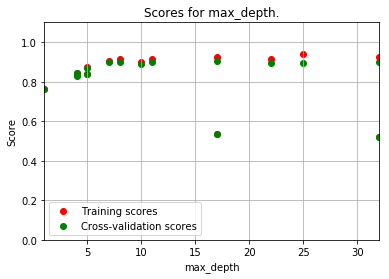

In [31]:
plot_grid_scores("max_depth", bayes_search.cv_results_)

In [32]:
bayes_search.best_params_

{'max_depth': 17, 'max_features': 96, 'min_samples_leaf': 38}

In [33]:
bayes_search.best_score_

0.90312348138963017

## Bonus questions

* try `RandomSearchCV` with a more complex estimator
* use the `sklearn` `Pipeline` class to incorporate your preprocessing steps in the hyper-parameter optimization.
* come back to this after learning about other ways of dealing with categorical values and treat different encoding schemes as a hyper-parameter that needs optimizing.